In [1]:
# 忽略warnings
import warnings 
warnings.filterwarnings('ignore') 

# 导入Python通用库
import matplotlib.pyplot as plt
# import numpy as np

# 导入TF 2.0并设置GPU
import tensorflow as tf
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
# 导入Keras库
from tensorflow import keras

# 导入util模块的各种方法
from keras.utils.np_utils import to_categorical
# 导入数据集
# from keras.datasets import imdb
from keras.datasets import mnist
# 导入模型、优化器、损失函数等等
from keras import regularizers
from keras import optimizers
from keras import metrics
from keras import models
from keras import losses
from keras import layers
# 导入Keras图像处理模块
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
# 导入系统库
import os

Using TensorFlow backend.


# 05. 深度学习用于计算机视觉
卷积神经网络，也叫`convnet`，是计算机视觉应用几乎都在使用的一种深度学习模型。你将学到将卷积神经网络应用于图像分类问题，特别是那些训练数据集较小的问题。如果你工作的地方并非大型科技公司，这也将是你最常见的使用场景。

## 5.1 卷积神经网络简介
我们先来看一个简单的卷积神经网络示例，即使用卷积神经网络对`MNIST`数字进行分类，这个任务我们在第2章用密集连接网络做过，当时的测试精度为`97.8%`。虽然本例中的卷积神经网络很简单，但其精度肯定会超过第2章的密集连接网络。

下列代码展示一个简单的卷积神经网络，它是`Conv2D`层和`MaxPooling2D`层的堆叠。

In [2]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

重要的是，卷积神经网络接收形状为`(image_height, image_width, image_channels)`的输入张量（不包括批量维度）。本例中设置卷积神经网络处理大小为`(28, 28, 1)`的输入张量，这正是`MNIST`图像的格式。我们向第一层传入参数`input_shape=(28, 28, 1)`来完成此设置。

我们来看一下目前卷积神经网络的架构。

In [3]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


可以看到，每个`Conv2D`层和`MaxPooling2D`层的输出都是一个形状为`(height, width, channels)`的3D张量。宽度和高度两个维度的尺寸通常会随着网络加深而变小。通道数量由传入`Conv2D`层的第一个参数所控制（32 或 64）。

下一步是将最后的输出张量［大小为`(3, 3, 64)`］输入到一个密集连接分类器网络中，即`Dense`层的堆叠，你已经很熟悉了。这些分类器可以处理`1D`向量，而当前的输出是`3D`张量。首先，我们需要将`3D`输出展平为`1D`，然后在上面添加几个`Dense`层。

In [4]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

我们将进行10类别分类，最后一层使用带10个输出的`softmax`激活。现在网络的架构如下。

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

如你所见，在进入两个`Dense`层之前，形状`(3, 3, 64)`的输出被展平为形状`(576,)`的向量。

下面我们在`MNIST`数字图像上训练这个卷积神经网络。

In [6]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
60000/60000 [==============================] - 7s 123us/step - loss: 0.1691 - accuracy: 0.9468
Epoch 2/5
60000/60000 [==============================] - 6s 105us/step - loss: 0.0451 - accuracy: 0.9857
Epoch 3/5
60000/60000 [==============================] - 6s 105us/step - loss: 0.0308 - accuracy: 0.9903
Epoch 4/5
60000/60000 [==============================] - 6s 105us/step - loss: 0.0231 - accuracy: 0.9930
Epoch 5/5
60000/60000 [==============================] - 6s 105us/step - loss: 0.0194 - accuracy: 0.9941


我们在测试数据上对模型进行评估。

In [7]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
test_acc

10000/10000 [==============================] - 1s 63us/step


0.9909999966621399

第2章密集连接网络的测试精度为`97.8%`，但这个简单卷积神经网络的测试精度达到了`99.3%`，我们将错误率降低了`68%`（相对比例）。相当不错！

与密集连接模型相比，为什么这个简单卷积神经网络的效果这么好？要回答这个问题，我们来深入了解`Conv2D`层和`MaxPooling2D`层的作用。

### 5.1.1 卷积运算
密集连接层和卷积层的根本区别在于，`Dense`层从输入特征空间中学到的是全局模式（比如对于`MNIST`数字，全局模式就是涉及所有像素的模式），而卷积层学到的是局部模式（见`图5-1`），对于图像来说，学到的就是在输入图像的二维小窗口中发现的模式。在上面的例子中，这些窗口的大小都是$3\times 3$。

<img src="images/05_01.png" style="width:450px;"/>

这个重要特性使卷积神经网络具有以下两个有趣的性质。
+ 卷积神经网络学到的模式具有`平移不变性`（translation invariant）。卷积神经网络在图像右下角学到某个模式之后，它可以在任何地方识别这个模式，比如左上角。对于密集连接网络来说，如果模式出现在新的位置，它只能重新学习这个模式。这使得卷积神经网络在处理图像时可以高效利用数据（因为视觉世界从根本上具有平移不变性），它只需要更少的训练样本就可以学到具有泛化能力的数据表示
+ 卷积神经网络可以学到模式的`空间层次结构`（spatial hierarchies of patterns），见`图5-2`。第一个卷积层将学习较小的局部模式（比如边缘），第二个卷积层将学习由第一层特征组成的更大的模式，以此类推。这使得卷积神经网络可以有效地学习越来越复杂、越来越抽象的视觉概念（因为视觉世界从根本上具有空间层次结构）

<img src="images/05_02.png" style="width:450px;"/>

对于包含两个空间轴（高度和宽度）和一个深度轴（也叫通道轴）的`3D`张量，其卷积也叫`特征图`（feature map）。对于`RGB`图像，深度轴的维度大小等于3，因为图像有3个颜色通道：红色、绿色和蓝色。对于黑白图像，深度等于1（表示灰度等级）。

卷积运算从输入特征图中提取图块，并对所有这些图块应用相同的变换，生成`输出特征图`（output feature map）。该输出特征图仍是一个`3D`张量，具有宽度和高度，其深度可以任意取值，因为输出深度是层的参数，深度轴的不同通道不再像`RGB`输入那样代表特定颜色，而是代表`过滤器`（filter）。过滤器对输入数据的某一方面进行编码，比如，单个过滤器可以从更高层次编码这样一个概念：“输入中包含一张脸”。

在`MNIST`示例中，第一个卷积层接收一个大小为`(28, 28, 1)`的特征图，并输出一个大小为`(26, 26, 32)`的特征图，即它在输入上计算32个过滤器。对于这32个输出通道，每个通道都包含一个`26×26`的数值网格，它是过滤器对输入的`响应图`（response map），表示这个过滤器模式在输入中不同位置的响应（见`图5-3`）。这也是特征图这一术语的含义：深度轴的每个维度都是一个特征（或过滤器），而`2D`张量`output[:, :, n]`是这个过滤器在输入上的响应的`二维空间图`（map）。

<img src="images/05_03.png" style="width:500px;"/>

卷积由以下两个关键参数所定义。
+ 从输入中提取的图块尺寸：这些图块的大小通常是$3 \times 3$或$5 \times 5$。本例中为$3 \times 3$，这是很常见的选择
+ 输出特征图的深度：卷积所计算的过滤器的数量。本例第一层的深度为32，最后一层的深度是64

对于`Keras`的`Conv2D`层，这些参数都是向层传入的前几个参数：`Conv2D(output_depth, (window_height, window_width))`。

卷积的工作原理：在`3D`输入特征图上滑动（slide）这些$3 \times 3$或$5 \times 5$的窗口，在每个可能的位置停止并提取周围特征的`3D`图块［形状为`(window_height, window_width, input_depth)`］。然后每个`3D`图块与学到的同一个权重矩阵［叫作`卷积核`（convolution kernel）］做张量积，转换成形状为`(output_depth,)` 的`1D`向量。然后对所有这些向量进行空间重组，使其转换为形状为`(height, width, output_depth)`的`3D`输出特征图。输出特征图中的每个空间位置都对应于输入特征图中的相同位置（比如输出的右下角包含了输入右下角的信息）。举个例子，利用$3 \times 3$的窗口，向量`output[i, j, :]`来自`3D`图块`input[i-1:i+1, j-1:j+1, :]`。整个过程详见`图5-4`。

<img src="images/05_04.png" style="width:400px;"/>

注意，输出的宽度和高度可能与输入的宽度和高度不同。不同的原因可能有两点：
+ 边界效应，可以通过对输入特征图进行填充来抵消。
+ 使用了步幅（stride）

我们来深入研究一下这些概念。

##### 1. 理解边界效应与填充
假设有一个$5\times 5$的特征图。其中只有 9 个方块可以作为中心放入一个$3 \times 3$的窗口，这9个方块形成一个$3 \times 3$的网格（见`图5-5`）。因此，输出特征图的尺寸是$3 \times 3$。它比输入尺寸小了一点，在本例中沿着每个维度都正好缩小了2个方块。

<img src="images/05_05.png" style="width:500px;"/>

如果你希望输出特征图的空间维度与输入相同，那么可以使用`填充`（padding）。填充是在输入特征图的每一边添加适当数目的行和列，使得每个输入方块都能作为卷积窗口的中心。对于$3 \times 3$的窗口，在左右各添加一列，在上下各添加一行。对于$3 \times 3$的窗口，各添加两行和两列（见`图5-6`）。

<img src="images/05_06.png" style="width:500px;"/>

对于`Conv2D`层，可以通过`padding`参数来设置填充，这个参数有两个取值：
+ `valid`表示不使用填充（只使用有效的窗口位置）
+ `same`表示“填充后输出的宽度和高度与输入相同”

`padding`参数的默认值为`valid`。

##### 2. 理解卷积步幅
影响输出尺寸的另一个因素是步幅的概念。目前为止，对卷积的描述都假设卷积窗口的中心方块都是相邻的。但两个连续窗口的距离是卷积的一个参数，叫作步幅，默认值为1。也可以使用`步进卷积`（strided convolution），即步幅大于1的卷积。在`图5-7`中，你可以看到用步幅为2的$3 \times 3$卷积从$5 \times 5$输入中提取的图块（无填充）。

<img src="images/05_07.png" style="width:400px;"/>

步幅为2意味着特征图的宽度和高度都被做了2倍下采样（除了边界效应引起的变化）。虽然步进卷积对某些类型的模型可能有用，但在实践中很少使用。熟悉这个概念是有好处的。

为了对特征图进行下采样，我们不用步幅，而是通常使用`最大池化`（max-pooling）运算。

### 5.1.2 最大池化运算
在卷积神经网络示例中，你可能注意到，在每个`MaxPooling2D`层之后，特征图的尺寸都会减半。这就是最大池化的作用：对特征图进行下采样，与步进卷积类似。

最大池化是从输入特征图中提取窗口，并输出每个通道的最大值。它的概念与卷积类似，但是最大池化使用硬编码的`max`张量运算对局部图块进行变换，而不是使用学到的线性变换（卷积核）。最大池化与卷积的最大不同之处在于，最大池化通常使用$2 \times 2$的窗口和步幅2，其目的是将特征图下采样2倍。与此相对的是，卷积通常使用$3 \times 3$窗口和步幅1。

为什么要用这种方式对特征图下采样？为什么不删除最大池化层，一直保留较大的特征图？我们来这么做试一下。这时模型的`卷积基`（convolutional base）如下所示。

In [8]:
model_no_max_pool = models.Sequential()
model_no_max_pool.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_no_max_pool.add(layers.Conv2D(64, (3, 3), activation='relu'))

model_no_max_pool.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 22, 22, 64)        36928     
Total params: 55,744
Trainable params: 55,744
Non-trainable params: 0
_________________________________________________________________


这种架构有如下两点问题：
+ 这种架构不利于学习特征的空间层级结构。第三层的$3 \times 3$窗口中只包含初始输入的$7 \times 7$窗口中所包含的信息。卷积神经网络学到的高级模式相对于初始输入来说仍然很小，这可能不足以学会对数字进行分类（你可以试试仅通过$7\times 7$像素的窗口观察图像来识别其中的数字）。我们需要让最后一个卷积层的特征包含输入的整体信息
+ 最后一层的特征图对每个样本共有$22 \times 22 \times 64 = 30976$个元素。这太多了。如果你将其展平并在上面添加一个大小为512的`Dense`层，那一层将会有1580万个参数。这对于这样一个小模型来说太多了，会导致严重的过拟合

简而言之，使用下采样的原因，一是减少需要处理的特征图的元素个数，二是通过让连续卷积层的观察窗口越来越大（即窗口覆盖原始输入的比例越来越大），从而引入空间过滤器的层级结构。

注意，最大池化不是实现这种下采样的唯一方法。你已经知道，还可以在前一个卷积层中使用步幅来实现。此外，你还可以使用平均池化来代替最大池化，其方法是将每个局部输入图块变换为取该图块各通道的平均值，而不是最大值。但最大池化的效果往往比这些替代方法更好。简而言之，原因在于特征中往往编码了某种模式或概念在特征图的不同位置是否存在（因此得名特征图），而观察不同特征的最大值而不是平均值能够给出更多的信息。因此，最合理的子采样策略是首先生成密集的特征图（通过无步进的卷积），然后观察特征每个小图块上的最大激活，而不是查看输入的稀疏窗口（通过步进卷积）或对输入图块取平均，因为后两种方法可能导致错过或淡化特征是否存在的信息。

## 5.2 在小型数据集上从头开始训练一个卷积神经网络
使用很少的数据来训练一个图像分类模型，这是很常见的情况，如果你要从事计算机视觉方面的职业，很可能会在实践中遇到这种情况。“很少的”样本可能是几百张图像，也可能是几万张图像。

来看一个实例，我们将重点讨论猫狗图像分类，数据集中包含4000张猫和狗的图像（2000张猫的图像，2000张狗的图像）。我们将2000张图像用于训练，1000张用于验证，1000张用于测试。

本节将介绍解决这一问题的基本策略，即使用已有的少量数据从头开始训练一个新模型。首先，在2000个训练样本上训练一个简单的小型卷积神经网络，不做任何正则化，为模型目标设定一个基准。这会得到71%的分类精度。此时主要的问题在于过拟合。然后，我们会介绍`数据增强`（data augmentation），它在计算机视觉领域是一种非常强大的降低过拟合的技术。使用数据增强之后，网络精度将提高到`82%`。

`5.3节`会介绍将深度学习应用于小型数据集的另外两个重要技巧：用预训练的网络做特征提取（得到的精度范围在`90%~96%`），对预训练的网络进行微调（最终精度为`97%`）。总而言之，这三种策略——从头开始训练一个小型模型、使用预训练的网络做特征提取、对预训练的网络进行微调——构成了你的工具箱，未来可用于解决小型数据集的图像分类问题。

### 5.2.1 深度学习与小数据问题的相关性
有时你会听人说，仅在有大量数据可用时，深度学习才有效。这种说法部分正确：深度学习的一个基本特性就是能够独立地在训练数据中找到有趣的特征，无须人为的特征工程，而这只在拥有大量训练样本时才能实现。对于输入样本的维度非常高（比如图像）的问题尤其如此。

但对于初学者来说，所谓“大量”样本是相对的，即相对于你所要训练网络的大小和深度而言。只用几十个样本训练卷积神经网络就解决一个复杂问题是不可能的，但如果模型很小，并做了很好的正则化，同时任务非常简单，那么几百个样本可能就足够了。由于卷积神经网络学到的是局部的、平移不变的特征，它对于感知问题可以高效地利用数据。虽然数据相对较少，但在非常小的图像数据集上从头开始训练一个卷积神经网络，仍然可以得到不错的结果，而且无须任何自定义的特征工程。

此外，深度学习模型本质上具有高度的可复用性，比如，已有一个在大规模数据集上训练的图像分类模型或语音转文本模型，你只需做很小的修改就能将其复用于完全不同的问题。特别是在计算机视觉领域，许多预训练的模型（通常都是在`ImageNet`数据集上训练得到的）现在都可以公开下载，并可以用于在数据很少的情况下构建强大的视觉模型。

### 5.2.2 下载数据
从[Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data)下载原始数据集，这些图像都是中等分辨率的彩色JPEG图像。`图5-8`给出了一些样本示例。

<img src="images/05_08.png" style="width:500px;"/>

2013年的猫狗分类Kaggle竞赛的优胜者使用的是卷积神经网络，最佳结果达到了`95%`的精度。本例中，我们只用`10%`的数据训练模型，但结果也和这个精度相当接近。

数据集包含25000张猫狗图像（每个类别都有12500张），大小为543MB（压缩后）。下载数据并解压之后，你需要创建一个新数据集，其中包含三个子集：每个类别各1000个样本的训练集、每个类别各500个样本的验证集和每个类别各500个样本的测试集。

这里省略了原文创建数据集的代码，直接使用我自己创建的小数据集：

In [9]:
train_cats_dir="./data/dogs-vs-cats/train/cats/"
train_dogs_dir="./data/dogs-vs-cats/train/dogs/"
validation_cats_dir="./data/dogs-vs-cats/validation/cats/"
validation_dogs_dir="./data/dogs-vs-cats/validation/dogs/"
test_cats_dir="./data/dogs-vs-cats/test/cats/"
test_dogs_dir="./data/dogs-vs-cats/test/dogs/"

print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


### 5.2.3 构建网络
在前一个`MNIST`示例中，我们构建了一个小型卷积神经网络。我们将复用相同的总体结构，即卷积神经网络由`Conv2D层`（使用`relu`激活）和`MaxPooling2D`层交替堆叠构成。

但由于这里要处理的是更大的图像和更复杂的问题，你需要相应地增大网络，即再增加一个`Conv2D+MaxPooling2D`的组合。这既可以增大网络容量，也可以进一步减小特征图的尺寸，使其在连接`Flatten`层时尺寸不会太大。本例中初始输入的尺寸为$150\times 150$（有些随意的选择），所以最后在`Flatten`层之前的特征图大小为$7 \times 7$。

> **注意**
> 
> 网络中特征图的深度在逐渐增大（从32增大到128），而特征图的尺寸在逐渐减小（从150×150减小到7×7）。这几乎是所有卷积神经网络的模式。
你面对的是一个二分类问题，所以网络最后一层是使用sigmoid激活的单一单元（大小为1的Dense层）。这个单元将对某个类别的概率进行编码。

In [10]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

我们来看一下特征图的维度如何随着每层变化。

In [11]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 15, 128)      

我们将使用`RMSprop`优化器。因为网络最后一层是单一`sigmoid`单元，所以我们将使用二元交叉熵作为损失函数（提醒一下，`表4-1`列出了各种情况下应该使用的损失函数）。

In [12]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

### 5.2.4 数据预处理
将数据输入神经网络之前，应该将数据格式化为经过预处理的浮点数张量。现在，数据以`JPEG`文件的形式保存在硬盘中，所以数据预处理步骤大致如下：
1. 读取图像文件
2. 将JPEG文件解码为RGB像素网格
3. 将这些像素网格转换为浮点数张量
4. 将像素值缩放到`[0, 1]`区间

这些步骤可能看起来有点吓人，但幸运的是，`Keras`拥有自动完成这些步骤的工具。`Keras`有一个图像处理辅助工具的模块`keras.preprocessing.image`。它包含`ImageDataGenerator`类，可以快速创建`Python`生成器，能够将硬盘上的图像文件自动转换为预处理好的张量批量。

In [13]:
train_dir="./data/dogs-vs-cats/train/"
test_dir="./data/dogs-vs-cats/test/"
validation_dir="./data/dogs-vs-cats/validation/"

train_datagen = ImageDataGenerator(rescale=1./255) 
test_datagen = ImageDataGenerator(rescale=1./255)    

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=20, class_mode='binary') 
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150), batch_size=20, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


我们来看一下其中一个生成器的输出：它生成了$150 \times 150$的`RGB`图像［形状为`(20, 150, 150, 3)`］与二进制标签［形状为`(20,)`］组成的批量。每个批量中包含20个样本（批量大小）。注意，生成器会不停地生成这些批量，它会不断循环目标文件夹中的图像。因此，你需要在某个时刻终止迭代循环。

In [14]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


利用生成器，我们让模型对数据进行拟合。我们将使用`fit_generator`方法来拟合，它在数据生成器上的效果和`fit`相同。它的第一个参数应该是一个`Python`生成器，可以不停地生成输入和目标组成的批量，比如`train_generator`。因为数据是不断生成的，所以`Keras`模型要知道每一轮需要从生成器中抽取多少个样本。这是`steps_per_epoch`参数的作用：从生成器中抽取`steps_per_epoch`个批量后（即运行了`steps_per_epoch`次梯度下降），拟合过程将进入下一个轮次。本例中，每个批量包含20个样本，所以读取完所有2000个样本需要100个批量。

使用`fit_generator`时，你可以传入一个`validation_data`参数，其作用和在`fit`方法中类似。值得注意的是，这个参数可以是一个数据生成器，但也可以是`Numpy`数组组成的元组。如果向`validation_data`传入一个生成器，那么这个生成器应该能够不停地生成验证数据批量，因此你还需要指定`validation_steps`参数，说明需要从验证生成器中抽取多少个批次用于评估。

In [15]:
history = model.fit_generator(
    train_generator, steps_per_epoch=100, epochs=30,
    validation_data=validation_generator, validation_steps=50)

Epoch 1/30
100/100 [==============================] - 10s 101ms/step - loss: 0.6875 - acc: 0.5425 - val_loss: 0.6637 - val_acc: 0.5970
Epoch 2/30
100/100 [==============================] - 9s 91ms/step - loss: 0.6471 - acc: 0.6215 - val_loss: 0.6155 - val_acc: 0.6120
Epoch 3/30
100/100 [==============================] - 9s 91ms/step - loss: 0.6012 - acc: 0.6680 - val_loss: 0.6231 - val_acc: 0.6630
Epoch 4/30
100/100 [==============================] - 9s 91ms/step - loss: 0.5664 - acc: 0.7100 - val_loss: 0.7099 - val_acc: 0.6480
Epoch 5/30
100/100 [==============================] - 9s 92ms/step - loss: 0.5327 - acc: 0.7275 - val_loss: 0.6297 - val_acc: 0.6540
Epoch 6/30
100/100 [==============================] - 9s 92ms/step - loss: 0.5059 - acc: 0.7550 - val_loss: 0.6173 - val_acc: 0.6900
Epoch 7/30
100/100 [==============================] - 9s 91ms/step - loss: 0.4775 - acc: 0.7690 - val_loss: 0.4665 - val_acc: 0.6940
Epoch 8/30
100/100 [==============================] - 9s 91ms/step 

始终在训练完成后保存模型，这是一种良好实践。

In [16]:
model.save('./model/cats_and_dogs_small_cpu_1.h5')

我们来分别绘制训练过程中模型在训练数据和验证数据上的损失和精度：

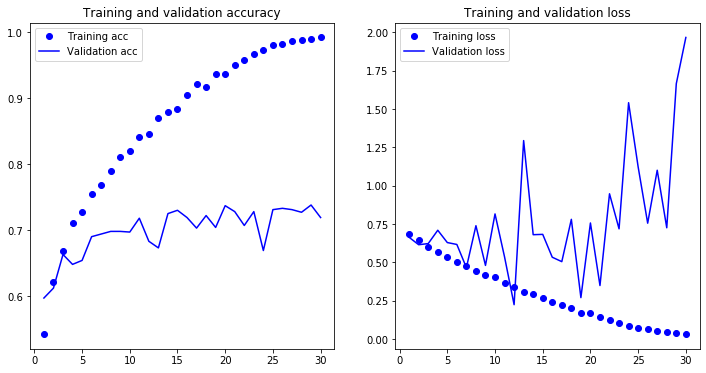

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

从这些图像中都能看出过拟合的特征。训练精度随着时间线性增加，直到接近`100%`，而验证精度则停留在`70%~72%`。验证损失仅在5轮后就达到最小值，然后保持不变，而训练损失则一直线性下降，直到接近于 0。

因为训练样本相对较少（2000个），所以过拟合是你最关心的问题。前面已经介绍过几种降低过拟合的技巧，比如`dropout`和`权重衰减`（L2正则化）。现在我们将使用一种针对于计算机视觉领域的新方法，在用深度学习模型处理图像时几乎都会用到这种方法，它就是`数据增强`（data augmentation）。

### 5.2.5 使用数据增强
过拟合的原因是学习样本太少，导致无法训练出能够泛化到新数据的模型。如果拥有无限的数据，那么模型能够观察到数据分布的所有内容，这样就永远不会过拟合。数据增强是从现有的训练样本中生成更多的训练数据，其方法是利用多种能够生成可信图像的随机变换来增加（augment）样本。其目标是，模型在训练时不会两次查看完全相同的图像。这让模型能够观察到数据的更多内容，从而具有更好的泛化能力。

在`Keras`中，这可以通过对`ImageDataGenerator`实例读取的图像执行多次随机变换来实现。

In [18]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

这里只选择了几个参数：
+ **rotation_range**是角度值（在`0~180`范围内），表示图像随机旋转的角度范围
+ **width_shift**和**height_shift**是图像在水平或垂直方向上平移的范围（相对于总宽度或总高度的比例）
+ **shear_range**是随机错切变换的角度
+ **zoom_range**是图像随机缩放的范围
+ **horizontal_flip**是随机将一半图像水平翻转。如果没有水平不对称的假设（比如真实世界的图像），这种做法是有意义的
+ **fill_mode**是用于填充新创建像素的方法，这些新像素可能来自于旋转或宽度/高度平移

我们来看一下增强后的图像：

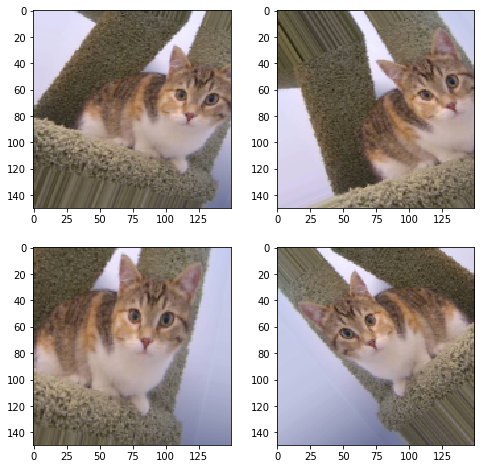

In [19]:
fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]
# 选择一张图像进行增强
img_path = fnames[3]
# 读取图像并调整大小
img = image.load_img(img_path, target_size=(150, 150))
# 将其转换为形状(150, 150, 3)的Numpy数组
x = image.img_to_array(img) 
# 将其形状改变为(1, 150, 150, 3)
x = x.reshape((1,) + x.shape) 
# 生成随机变换后的图像批量。循环是无限的，因此你需要在某个时刻终止循环
i = 0
plt.figure(figsize=(8, 8))
for batch in datagen.flow(x, batch_size=1):
    # plt.figure(i) 
    plt.subplot(221+i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

如果你使用这种数据增强来训练一个新网络，那么网络将不会两次看到同样的输入。但网络看到的输入仍然是高度相关的，因为这些输入都来自于少量的原始图像。你无法生成新信息，而只能混合现有信息。因此，这种方法可能不足以完全消除过拟合。为了进一步降低过拟合，你还需要向模型中添加一个`Dropout` 层，添加到密集连接分类器之前。

In [20]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

我们来训练这个使用了`数据增强`和`dropout`的网络。

In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# 注意，不能增强验证数据
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='binary') 
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150), batch_size=32, class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50, verbose=1)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 19s 185ms/step - loss: 0.6923 - acc: 0.5292 - val_loss: 0.6967 - val_acc: 0.5209
Epoch 2/100
100/100 [==============================] - 17s 172ms/step - loss: 0.6806 - acc: 0.5644 - val_loss: 0.7386 - val_acc: 0.5161
Epoch 3/100
100/100 [==============================] - 17s 168ms/step - loss: 0.6620 - acc: 0.5994 - val_loss: 0.6057 - val_acc: 0.6358
Epoch 4/100
100/100 [==============================] - 18s 179ms/step - loss: 0.6505 - acc: 0.6184 - val_loss: 0.6746 - val_acc: 0.6463
Epoch 5/100
100/100 [==============================] - 17s 168ms/step - loss: 0.6410 - acc: 0.6171 - val_loss: 0.6914 - val_acc: 0.6555
Epoch 6/100
100/100 [==============================] - 19s 187ms/step - loss: 0.6228 - acc: 0.6490 - val_loss: 0.6931 - val_acc: 0.6179
Epoch 7/100
100/100 [==============================] - 17s 172ms/step - loss: 0.6014 - acc: 0.6643 -

100/100 [==============================] - 17s 174ms/step - loss: 0.4117 - acc: 0.8103 - val_loss: 0.5498 - val_acc: 0.7900
Epoch 61/100
100/100 [==============================] - 18s 176ms/step - loss: 0.4042 - acc: 0.8122 - val_loss: 0.3777 - val_acc: 0.7867
Epoch 62/100
100/100 [==============================] - 18s 180ms/step - loss: 0.4003 - acc: 0.8122 - val_loss: 0.5626 - val_acc: 0.7360
Epoch 63/100
100/100 [==============================] - 18s 177ms/step - loss: 0.4019 - acc: 0.8191 - val_loss: 0.4482 - val_acc: 0.8061
Epoch 64/100
100/100 [==============================] - 17s 171ms/step - loss: 0.3956 - acc: 0.8245 - val_loss: 0.1658 - val_acc: 0.8196
Epoch 65/100
100/100 [==============================] - 17s 174ms/step - loss: 0.3999 - acc: 0.8119 - val_loss: 0.4936 - val_acc: 0.8223
Epoch 66/100
100/100 [==============================] - 17s 173ms/step - loss: 0.3996 - acc: 0.8191 - val_loss: 0.2535 - val_acc: 0.8086
Epoch 67/100
100/100 [==============================] 

我们把模型保存下来，你会在`5.4`节用到它。

In [22]:
model.save('./model/cats_and_dogs_small_2.h5')

我们再次绘制结果。使用了数据增强和 dropout 之后，模型不再过拟合：训练曲线紧紧跟随着验证曲线。现在的精度为`82%`，比未正则化的模型提高了`15%`（相对比例）。

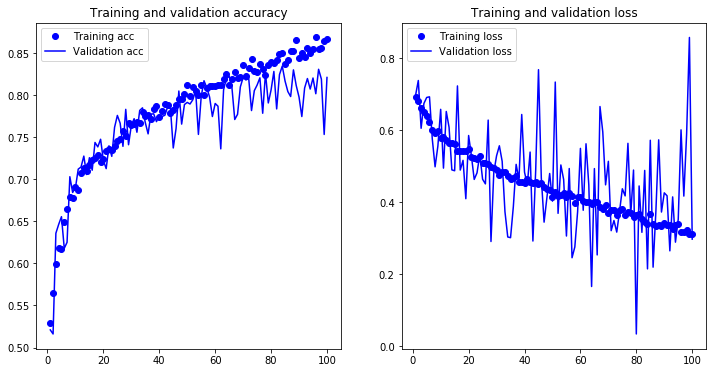

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()